# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
from scipy import  stats as st
import math
import matplotlib.pyplot as plt
import seaborn as sns



## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
calls= pd.read_csv('/datasets/megaline_calls.csv')
internet= pd.read_csv('/datasets/megaline_internet.csv')
messages= pd.read_csv('/datasets/megaline_messages.csv')
plans= pd.read_csv('/datasets/megaline_plans.csv')
users= pd.read_csv('/datasets/megaline_users.csv')


## Preparar los datos

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
plans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas
print(plans.head())

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  




**Los tipos de datos me parecen adecuados para el análisis, sin embargo observo que hay una discrepancia en la columna "usd_monthly_pay", debería ser 'usd_monthly_fee', se puede arreglar renombrando la columna**

## Corregir datos

In [5]:
plans.rename(columns={'usd_monthly_pay':'usd_monthly_fee'},inplace=True)
plans.columns

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'usd_monthly_fee', 'usd_per_gb', 'usd_per_message', 'usd_per_minute',
       'plan_name'],
      dtype='object')

## Usuarios/as

In [6]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
# Imprime una muestra de datos para usuarios
print(users.sample(5))


     user_id first_name last_name  age  \
199     1199  Antonetta    Finley   39   
202     1202    Osvaldo     Mayer   36   
319     1319     Eliseo    Carson   21   
64      1064    Gerardo    Ashley   46   
317     1317   Ruthanne     Heath   70   

                                            city    reg_date      plan  \
199            San Antonio-New Braunfels, TX MSA  2018-08-01  ultimate   
202  Minneapolis-St. Paul-Bloomington, MN-WI MSA  2018-09-30  ultimate   
319                     Colorado Springs, CO MSA  2018-06-17      surf   
64     New York-Newark-Jersey City, NY-NJ-PA MSA  2018-06-03      surf   
317                Phoenix-Mesa-Chandler, AZ MSA  2018-11-11  ultimate   

    churn_date  
199        NaN  
202        NaN  
319        NaN  
64         NaN  
317        NaN  


**Podemos observar que los datos de 'reg_date' y 'churn_date' son de tipo objeto, debemos cambiarlos a tipo datetime para poder compararlos entre si y obtener cortes periodicos**

### Corregir los datos

In [8]:
users['reg_date']= pd.to_datetime(users['reg_date'],format='%Y-%m-%d')
users['churn_date']= pd.to_datetime(users['churn_date'],format='%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [9]:
users['bill']=0.0


In [10]:
print(users.sample(2))

     user_id first_name   last_name  age  \
498     1498       Scot  Williamson   51   
263     1263      Lucio       Duffy   39   

                                          city   reg_date  plan churn_date  \
498  New York-Newark-Jersey City, NY-NJ-PA MSA 2018-02-04  surf        NaT   
263         Boston-Cambridge-Newton, MA-NH MSA 2018-03-06  surf        NaT   

     bill  
498   0.0  
263   0.0  


### Enriquecer los datos

In [11]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


## Llamadas

In [12]:
# Imprime una muestra de datos para las llamadas
print(calls.sample(2))


             id  user_id   call_date  duration
77631  1277_707     1277  2018-10-31       0.0
13301  1057_180     1057  2018-10-19       0.0




* **Observamos que el tipo de dato de la columna 'call_date' es object, cuando debería ser datetime**


### Corregir los datos

In [13]:
calls['call_date']=pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls.info()
calls.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


,id,user_id,call_date,duration
134216,1488_367,1488,2018-07-22,6.86
34713,1130_233,1130,2018-12-30,3.36


### Enriquecer los datos

In [14]:
calls['month']= calls['call_date'].dt.month
calls.head()
#print(calls['call_date'].dt.month)

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,8.52,12
1,1000_145,1000,2018-12-27,13.66,12
2,1000_247,1000,2018-12-27,14.48,12
3,1000_309,1000,2018-12-28,5.76,12
4,1000_380,1000,2018-12-30,4.22,12


## Mensajes

In [15]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
messages.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [16]:
# Imprime una muestra de datos para los mensajes
print(messages.sample(2))

              id  user_id message_date
36970   1247_134     1247   2018-08-07
21896  1132_1424     1132   2018-10-15


* **El tipo de dato de la columna 'message_date' es object, cuando debería ser datetime**

### Corregir los datos

In [17]:
messages['message_date']=pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()
print(messages.sample(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB
             id  user_id message_date
14302  1098_327     1098   2018-10-25
19512  1126_199     1126   2018-12-26


### Enriquecer los datos

In [18]:
messages['month']= messages['message_date'].dt.month
messages.head()

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


## Internet

In [19]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [20]:
# Imprime una muestra de datos para el tráfico de internet
internet.sample(2)


,id,user_id,session_date,mb_used
47031,1210_129,1210,2018-06-15,620.08
61321,1278_167,1278,2018-12-24,569.11



* **El tipo de dato de la columna 'session_date' es object cuando debería ser datetime**

### Corregir los datos

In [21]:
internet['session_date']=pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet.info()
print(internet.sample(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB
             id  user_id session_date  mb_used
30920  1141_264     1141   2018-07-16      0.0
46764  1207_102     1207   2018-12-27    390.5


### Enriquecer los datos

In [22]:
internet['month']= internet['session_date'].dt.month
internet.head()

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12


## Estudiar las condiciones de las tarifas

In [23]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
plans.info()
plans


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_fee        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,usd_monthly_fee,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Agregar datos por usuario


In [24]:
calls['duration']=np.ceil(calls['duration'])

In [25]:
mins= calls.groupby(['user_id','month']).sum().sort_values(by='user_id')
mins.reset_index(inplace=True)
print(mins)

      user_id  month  duration
0        1000     12     124.0
1        1001      8     182.0
2        1001      9     315.0
3        1001     10     393.0
4        1001     11     426.0
...       ...    ...       ...
2253     1498      6     238.0
2254     1499     10     385.0
2255     1499     11     308.0
2256     1499      9     346.0
2257     1499     12     496.0

[2258 rows x 3 columns]


In [26]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
call= calls.groupby(['user_id','month']).count().sort_values(by='user_id')

call.reset_index(inplace=True)

call= call[['user_id','month','id']]
call.rename(columns={'id':'call_q'},inplace=True)
print(call)


      user_id  month  call_q
0        1000     12      16
1        1001      8      27
2        1001      9      49
3        1001     10      65
4        1001     11      64
...       ...    ...     ...
2253     1498      6      37
2254     1499     10      53
2255     1499     11      45
2256     1499      9      41
2257     1499     12      65

[2258 rows x 3 columns]


In [27]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
print(mins.head())
#print(mins[mins['user_id']==1001])


   user_id  month  duration
0     1000     12     124.0
1     1001      8     182.0
2     1001      9     315.0
3     1001     10     393.0
4     1001     11     426.0


In [28]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
message= messages.groupby(['user_id','month']).count().sort_values(by='user_id')

message.reset_index(inplace=True)
message_q= message[['user_id','month','id']]
message_q.rename(columns={'id':'message_q'}, inplace=True)
message_q['message_q']= message_q['message_q'].astype(float)
print(message_q)


      user_id  month  message_q
0        1000     12       11.0
1        1001      8       30.0
2        1001      9       44.0
3        1001     10       53.0
4        1001     11       36.0
...       ...    ...        ...
1801     1496     10       18.0
1802     1496     12       11.0
1803     1496      8        2.0
1804     1496      9       21.0
1805     1497     12       50.0

[1806 rows x 3 columns]


/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/tmp/ipykernel_1353/916939341.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  message_q['message_q']= message_q['message_q'].astype(float)


In [29]:
internet.head()

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12


In [30]:
internet['mb_used']=np.ceil(internet['mb_used'])

In [31]:
internet['mb_used']=(internet['mb_used']/1024)

In [32]:
internet.rename(columns={'mb_used':'gb_used'},inplace=True)
internet.head()

,id,user_id,session_date,gb_used,month
0,1000_13,1000,2018-12-29,0.087891,12
1,1000_204,1000,2018-12-31,0.000000,12
2,1000_379,1000,2018-12-28,0.645508,12
3,1000_413,1000,2018-12-26,0.264648,12
4,1000_442,1000,2018-12-27,0.860352,12


In [33]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
web_t= internet.groupby(['user_id','month']).sum().sort_values(by='user_id')
web_t.reset_index(inplace=True)

print(web_t)



      user_id  month    gb_used
0        1000     12   1.858398
1        1001      8   6.766602
2        1001      9  13.020508
3        1001     10  21.832031
4        1001     11  18.089844
...       ...    ...        ...
2272     1498      6  14.477539
2273     1499     10  19.057617
2274     1499     11  16.439453
2275     1499      9  12.699219
2276     1499     12  21.573242

[2277 rows x 3 columns]


In [34]:
print(mins[mins['user_id']==1001])
print('/')
print(message_q[message_q['user_id']==1001])
print('/')
print(web_t[web_t['user_id']==1001])


   user_id  month  duration
1     1001      8     182.0
2     1001      9     315.0
3     1001     10     393.0
4     1001     11     426.0
5     1001     12     412.0
/
   user_id  month  message_q
1     1001      8       30.0
2     1001      9       44.0
3     1001     10       53.0
4     1001     11       36.0
5     1001     12       44.0
/
   user_id  month    gb_used
1     1001      8   6.766602
2     1001      9  13.020508
3     1001     10  21.832031
4     1001     11  18.089844
5     1001     12  18.943359


In [35]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
merged_df = pd.merge(mins, message_q, on=['user_id','month'])
merged_df= pd.merge(merged_df, web_t, on=['user_id','month'])

merged_df



,user_id,month,duration,message_q,gb_used
0,1000,12,124.0,11.0,1.858398
1,1001,8,182.0,30.0,6.766602
2,1001,9,315.0,44.0,13.020508
3,1001,10,393.0,53.0,21.832031
4,1001,11,426.0,36.0,18.089844
...,...,...,...,...,...
1754,1496,11,308.0,13.0,8.360352
1755,1496,9,414.0,21.0,16.027344
1756,1496,8,122.0,2.0,8.414062
1757,1496,10,317.0,18.0,13.972656


In [36]:
plans['mb_per_month_included']=(plans['mb_per_month_included']/1024)

In [37]:
plans.rename(columns={'mb_per_month_included':'gb_per_month_included'},inplace=True)
plans

,messages_included,gb_per_month_included,minutes_included,usd_monthly_fee,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


In [38]:
# Añade la información de la tarifa
mdf= pd.merge(merged_df,users, left_on =['user_id'], right_on=['user_id'])
mdf.rename(columns={'mb_used_y':'mb_used'},inplace=True)
mdf.drop(['first_name','last_name','age','reg_date','churn_date'], axis=1, inplace=True)
mdf['gb_used']=np.ceil(mdf['gb_used'])
#mdf.bill=mdf.bill.astype(float)

mdf



,user_id,month,duration,message_q,gb_used,city,plan,bill
0,1000,12,124.0,11.0,2.0,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,0.0
1,1001,8,182.0,30.0,7.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,0.0
2,1001,9,315.0,44.0,14.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,0.0
3,1001,10,393.0,53.0,22.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,0.0
4,1001,11,426.0,36.0,19.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,0.0
...,...,...,...,...,...,...,...,...
1754,1496,11,308.0,13.0,9.0,"New Orleans-Metairie, LA MSA",surf,0.0
1755,1496,9,414.0,21.0,17.0,"New Orleans-Metairie, LA MSA",surf,0.0
1756,1496,8,122.0,2.0,9.0,"New Orleans-Metairie, LA MSA",surf,0.0
1757,1496,10,317.0,18.0,14.0,"New Orleans-Metairie, LA MSA",surf,0.0


In [39]:
plans

,messages_included,gb_per_month_included,minutes_included,usd_monthly_fee,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


In [40]:
# Calcula el ingreso mensual para cada usuario
for i in range (len(mdf)):

    plan= [mdf.loc[i,'plan']]

    bill= plans[plans['plan_name'].isin(plan)]['usd_monthly_fee'].astype(float)

    message_inc=plans[plans['plan_name'].isin(plan)]['messages_included'].reset_index(drop=True)

    gb_inc =plans[plans['plan_name'].isin(plan)]['gb_per_month_included'].reset_index(drop=True)

    min_inc=plans[plans['plan_name'].isin(plan)]['minutes_included'].reset_index(drop=True)


    usd_month=plans[plans['plan_name'].isin(plan)]['usd_monthly_fee'].reset_index(drop=True)


    usd_pgb=plans[plans['plan_name'].isin(plan)]['usd_per_gb'].reset_index(drop=True)
    usd_pmess=plans[plans['plan_name'].isin(plan)]['usd_per_message'].reset_index(drop=True)
    usd_pmin= plans[plans['plan_name'].isin(plan)]['usd_per_minute'].reset_index(drop=True)


    #print(mdf['duration'][i])
    if mdf['duration'][i] > min_inc[0]:
        bill+=(mdf['duration'][i]-min_inc)* (usd_pmin)

    if mdf['message_q'][i] > message_inc[0]:
        bill+=(mdf['message_q'][i]- message_inc)* (usd_pmess)
    #print(i,mb_inc[0])
    
    if mdf['gb_used'][i] > gb_inc[0]:
        bill+= (mdf['gb_used'][i] - gb_inc[0]) *(usd_pgb[0])
        
#     print(i,mdf['gb_used'][i], 'indice ,gb utilizados')
#     print(gb_inc[0], 'gb incl')
#     print(bill)
        #bill+= math.ceil((mdf['mb_used'][i] - mb_inc[0])/1024) *(usd_pgb[0])

    mdf['bill'][i]=bill



/tmp/ipykernel_1353/1825114458.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf['bill'][i]=bill


In [41]:
mdf.head()


,user_id,month,duration,message_q,gb_used,city,plan,bill
0,1000,12,124.0,11.0,2.0,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,70.00
1,1001,8,182.0,30.0,7.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,20.00
2,1001,9,315.0,44.0,14.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,20.00
3,1001,10,393.0,53.0,22.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,90.09
4,1001,11,426.0,36.0,19.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,60.00


<div class="alert alert-block alert-info">
<b>Respuesta del estudiante: Se realiza el cálculo de tarifas correcto con los nuevos datos previamente calculados: duration de calls redondeada a np.ceil, mb_used trasnformada a GB y redondeada hacia arriba, MB a GB en tabla plans</b> <a class="tocSkip"></a>
</div>

## Estudia el comportamiento de usuario

### Llamadas

In [42]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
month_mean_c= mdf.groupby(['month','plan']).mean()['duration']

month_mean_c=month_mean_c.reset_index()
m_ult=month_mean_c[month_mean_c['plan']=='ultimate']
m_surf=month_mean_c[month_mean_c['plan']=='surf']

m_join=pd.merge(m_surf,m_ult, on='month')
m_join.rename(columns={'duration_x':'surf','duration_y':'ultimate'},inplace=True)
m_join.index=np.arange(1,len(m_join)+1)
m_join.drop(['plan_x','plan_y'],axis=1,inplace=True)
m_join

,month,surf,ultimate
1,1,292.000000,197.666667
2,2,331.200000,486.800000
3,3,344.937500,415.285714
4,4,366.228571,322.750000
5,5,443.981132,410.190476
6,6,425.514286,370.918919
7,7,452.101124,439.638298
8,8,427.873950,436.438596
9,9,426.020408,437.591549
10,10,442.348066,465.034091


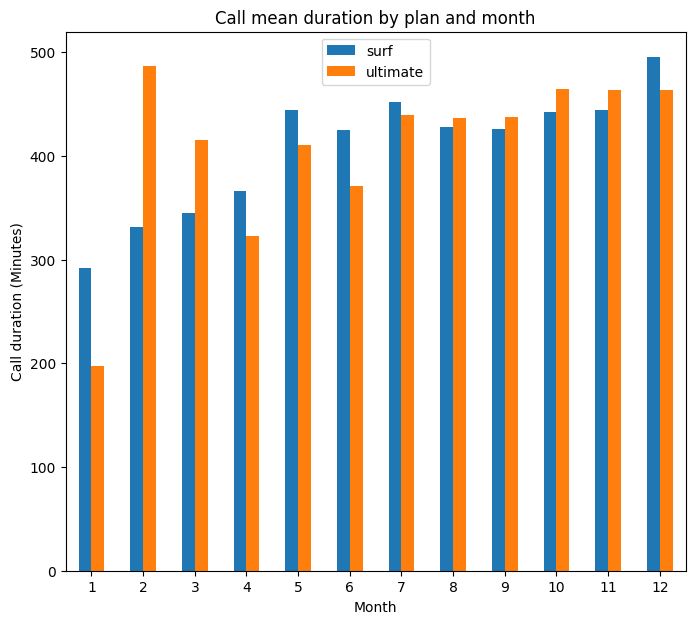

In [43]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
m_join[['surf','ultimate']].plot(kind='bar',rot=0, figsize=[8,7],
                                 xlabel='Month', ylabel='Call duration (Minutes)', title='Call mean duration by plan and month')

plt.legend(loc='upper center')
plt.show()


Media de minutos usados por usuario en plan Surf:  445.77542372881356
Media de minutos usados por usuario en plan Ultimate:  442.51295336787564


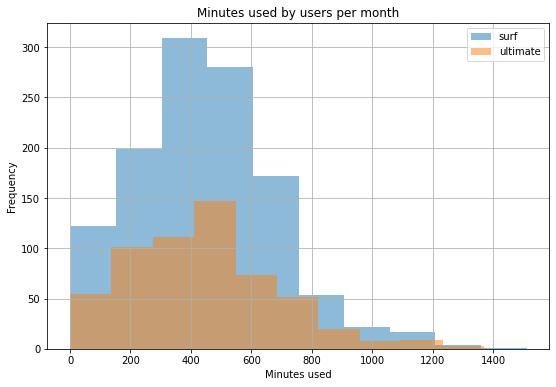

In [45]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
#mdf.head(60)
#mdf[mdf[]]
print('Media de minutos usados por usuario en plan Surf: ',mdf[mdf['plan']=='surf']['duration'].mean())
print('Media de minutos usados por usuario en plan Ultimate: ',mdf[mdf['plan']=='ultimate']['duration'].mean())
mdf[mdf['plan']=='surf']['duration'].hist( alpha=.5,figsize=[9,6])
mdf[mdf['plan']=='ultimate']['duration'].hist( alpha=.5)


plt.legend(['surf','ultimate'])
plt.title('Minutes used by users per month')
plt.ylabel('Frequency')
plt.xlabel('Minutes used')
plt.show()


In [46]:
# Calcula la media y la varianza de la duración mensual de llamadas.
m_variance = np.var(m_join)
m_mean= m_join.mean()
print(f"La duración media de las llamadas mensuales del plan Surf es : {m_mean.surf} minutos")
print(f"La varianza de las llamadas del plan Surf es : {m_variance.surf}")
print('')
print(f"La duración media de las llamadas mensuales del plan Ultimate es : {m_mean.ultimate} minutos")
print(f"La varianza de las llamadas del plan Ultimate es : {m_variance.ultimate}")


La duración media de las llamadas mensuales del plan Surf es : 407.60235591555823 minutos
La varianza de las llamadas del plan Surf es : 3282.800169307338

La duración media de las llamadas mensuales del plan Ultimate es : 409.13991150676594 minutos
La varianza de las llamadas del plan Ultimate es : 5939.502400280434


Text(0.5, 1.0, 'Monthly calls duration')

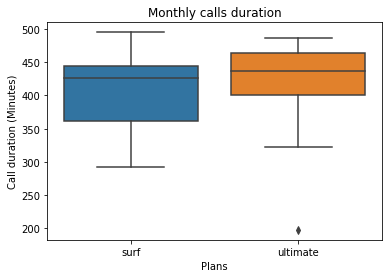

In [47]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
box= m_join.drop('month',axis=1)
box= pd.melt(box)
sns.boxplot(x='variable', y='value', data=box)
sns.set(rc={"figure.figsize":(9, 8)})
plt.ylabel('Call duration (Minutes)')
plt.xlabel('Plans')
plt.title('Monthly calls duration')




**Conclusiones:**


 
* **Para el plan 'Surf' podemos observar que el comportamiento de los usuarios si obedece a la función del plan, esto debido a que:**
    * La duración media de las llamadas mensuales de este plan es de 407 minutos, lo cual entra en el límite de 500 minutos de tarifa base
    * Se observa un sesgo negativo en este plan, generando una cola hacia la izquierda
    * El 50% de las llamadas duran entre los 360 y los 440 minutos
    * se observa una distribución oscilando entre los 290 y 490 minutos mensuales, esto está dentro del límite establecido de 500 minutos mensuales 


* **Para el plan 'Ultimate' podemos observar que el comportamiento de los usuarios respecto a las llamadas no precisamente obedece a la función del plan, esto debido a que:**
  * La cantidad de minutos que incluye el paquete 'Ultimate' son excesivos en relación a lo que utiliza la media de clientes en ese plan (409 minutos)
  * La media del plan es muy similar a la media del plan 'Surf', no observamos un cambio muy considerable a pesar de que tienen 6 veces más cantidad de minutos disponibles que el plan Surf
  * se observa un valor outlier cercano a los 200 minutos utilizados correspondiente al mes de enero, esto puede ser debido a diferentes causas, tal vez causas sociales como poco tráfico de llamadas después de las fiestas decembrinas, causas económicas como poca cantidad de clientes con contrato activo en ese mes, etc.
  


**En conclusión, el comportamiento de los usuarios respecto a las llamadas *si* varía en función del plan, podemos observar que los usuarios del plan Surf no suelen exceder la cantidad límite de minutos incluidos, sin embargo los usuarios del plan Ultimate, se quedan muy por debajo de la cantidad límite de minutos incluidos en su plan, esto puede deberse a que los usuarios Ultimate contraten el plan por otros beneficios como los datos móviles**


### Mensajes

In [48]:
# Compara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
month_mean_m=mdf.groupby(['month','plan'])['message_q'].mean()

month_mean_m=month_mean_m.reset_index()
mes_ult=month_mean_m[month_mean_m['plan']=='ultimate']
mes_surf=month_mean_m[month_mean_m['plan']=='surf']

mes_merged=pd.merge(mes_surf,mes_ult, on='month')
mes_merged.rename(columns={'message_q_x':'surf','message_q_y':'ultimate'},inplace=True)
mes_merged.index=np.arange(1,len(mes_merged)+1)
mes_merged.drop(['plan_x','plan_y'],axis=1,inplace=True)
mes_merged



,month,surf,ultimate
1,1,21.000000,20.666667
2,2,21.600000,27.800000
3,3,21.937500,34.714286
4,4,24.685714,28.937500
5,5,33.547170,44.333333
6,6,32.742857,37.135135
7,7,34.786517,41.212766
8,8,37.302521,47.929825
9,9,38.585034,45.901408
10,10,41.475138,47.488636


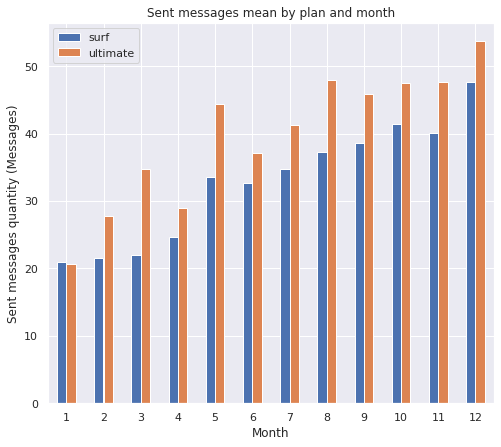

In [49]:
mes_merged[['surf','ultimate']].plot(kind='bar',rot=0, figsize=[8,7],
                                 xlabel='Month', ylabel='Sent messages quantity (Messages)', title='Sent messages mean by plan and month')

plt.legend(loc='upper left')
plt.show()


Media de mensajes enviados por usuario en plan Surf:  39.489830508474576
Media de mensajes enviados por usuario en plan Ultimate:  46.4559585492228


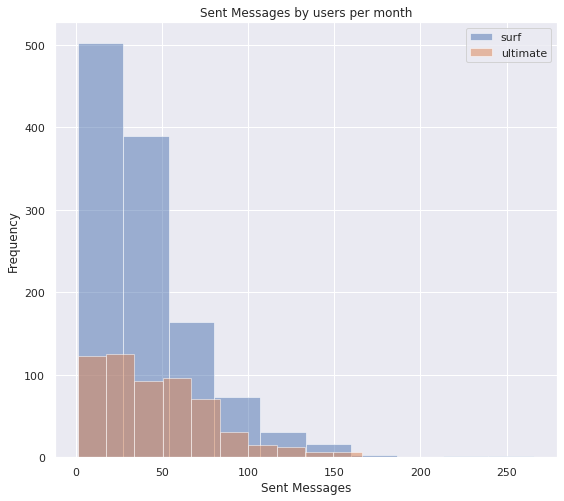

In [51]:
print('Media de mensajes enviados por usuario en plan Surf: ',mdf[mdf['plan']=='surf']['message_q'].mean())
print('Media de mensajes enviados por usuario en plan Ultimate: ',mdf[mdf['plan']=='ultimate']['message_q'].mean())
mdf[mdf['plan']=='surf']['message_q'].hist( alpha=.5,figsize=[9,8])
mdf[mdf['plan']=='ultimate']['message_q'].hist( alpha=.5)


plt.legend(['surf','ultimate'])
plt.title('Sent Messages by users per month')
plt.ylabel('Frequency')
plt.xlabel('Sent Messages')
plt.show()

In [52]:
# Calcula la media y la varianza de la cantidad mensual de mensajes enviados.
m_variance = np.var(mes_merged)
m_mean= mes_merged.mean()
print(f"La cantidad media de mensajes mensuales enviados del plan Surf es : {m_mean.surf} mensajes")
print(f"La varianza de los mensajes enviados del plan Surf es : {m_variance.surf}")
print('')
print(f"La cantidad media de mensajes mensuales enviados del plan Ultimate es : {m_mean.ultimate} mensajes")
print(f"La varianza de los mensajes enviados del plan Ultimate es : {m_variance.ultimate}")


La cantidad media de mensajes mensuales enviados del plan Surf es : 32.953049922550164 mensajes
La varianza de los mensajes enviados del plan Surf es : 71.37206076397557

La cantidad media de mensajes mensuales enviados del plan Ultimate es : 39.79336824397581 mensajes
La varianza de los mensajes enviados del plan Ultimate es : 91.84938550389963


Text(0.5, 1.0, 'Sent Messages')

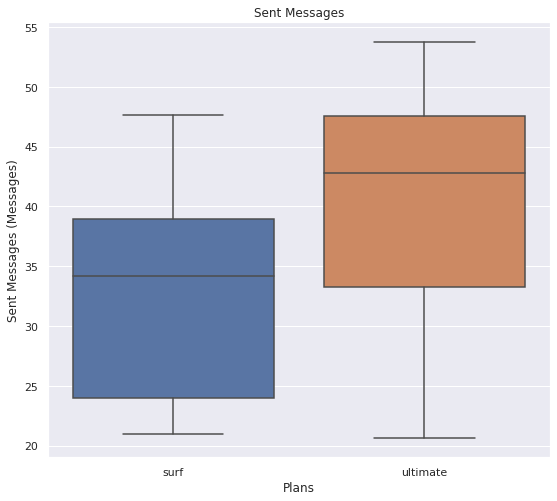

In [53]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
box= mes_merged.drop('month',axis=1)
box= pd.melt(box)
sns.boxplot(x='variable', y='value', data=box)
sns.set(rc={"figure.figsize":(9, 8)})
plt.ylabel('Sent Messages (Messages)')
plt.xlabel('Plans')
plt.title('Sent Messages')

**Conclusiones:**
* **Para el plan 'Surf' podemos observar que el comportamiento de los usuarios respecto a las mensajes si obedece a la función del plan, esto debido a que:**
  * La cantidad media de mensajes enviados al mes es de casi 33 mensajes, esto por debajo del límite de 50 mensajes incluidos mensualmente.
  * podemos observar que la distribución tiene un sesgo negativo, esto nos indica que la media tiene un valor menor que la mediana, por lo tanto se genera una cola hacia la izquierda
  * El 50% de los usuarios de este plan oscila entre los 24 y 38 mensajes enviados, la distribución tiene un rango aproximado entre los 22 y 48 mensajes enviados.
  * Todos estos datos nos indican que nuestros usuarios utilizan el plan surf dentro de los límites establecidos utilizando al menos el 50% de su capacidad mensual de mensajes.
  
  
  
* **Para el plan 'Ultimate' podemos observar que el comportamiento de los usuarios no obedece a la función del plan, esto debido a que:**
    * La media de mensajes enviados mensualmente se encuentra cerca de los 40 mensajes, cerca de 25 veces menos que el límite incluido, podemos observar que la distribución tiene un sesgo negativo, esto indica que la media tiene un valor menor que la mediana, por lo tanto se genera una cola hacia la izquierda.
    * El 50% de los usuarios de este plan oscila entre los 34 y 48 mensajes enviados, la distribución tiene un rango aproximado entre los 22 y 53 mensajes enviados.
    * los usuarios de este plan consumen en promedio el 4% de su capacidad de mensajes mensuales
    
**En conclusión, el comportamiento de los usuarios respecto a los mensajes *si* varía en función del plan, a pesar de esto, los usuarios que se comportan de una manera más "eficiente" respecto al consumo de mensajes incluidos son los usuarios del plan Surf, en su contraparte, los usuarios del plan Ultimate utilizan menos del 10% de su capacidad incluida.**

### Internet

In [54]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
month_mean_i=mdf.groupby(['month','plan'])['gb_used'].mean()

month_mean_i=month_mean_i.reset_index()
int_ult=month_mean_i[month_mean_i['plan']=='ultimate']
int_surf=month_mean_i[month_mean_i['plan']=='surf']

int_merged=pd.merge(int_surf,int_ult, on='month')
int_merged.rename(columns={'gb_used_x':'surf','gb_used_y':'ultimate'},inplace=True)
int_merged.index=np.arange(1,len(mes_merged)+1)
int_merged.drop(['plan_x','plan_y'],axis=1,inplace=True)
int_merged

,month,surf,ultimate
1,1,8.000000,7.333333
2,2,9.400000,17.400000
3,3,12.625000,23.857143
4,4,12.085714,14.500000
5,5,15.056604,17.238095
6,6,15.771429,15.540541
7,7,16.842697,16.638298
8,8,17.260504,18.035088
9,9,16.612245,16.507042
10,10,17.546961,17.647727


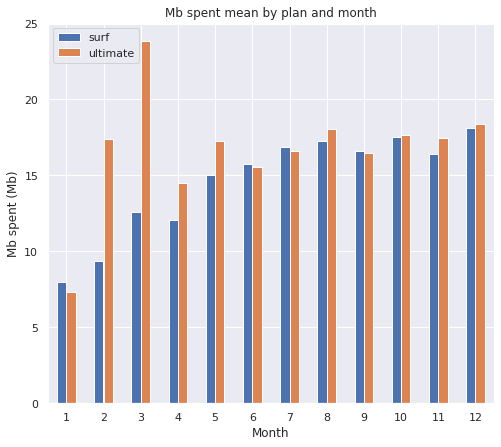

In [55]:
int_merged[['surf','ultimate']].plot(kind='bar',rot=0, figsize=[8,7],
                                 xlabel='Month', ylabel='Mb spent (Mb)', title='Mb spent mean by plan and month')

plt.legend(loc='upper left')
plt.show()

In [56]:
# # Compara el número de Mb mensuales que necesitan los usuarios de cada plan. Traza un histograma.
# int_merged['surf'].hist(bins=4, alpha=.5)
# int_merged['ultimate'].hist(bins=4, alpha=.5)
# plt.legend(['surf','ultimate'])
# plt.title('Mb spent by users per month')
# plt.ylabel('Frequency')
# plt.xlabel('Mb spent')
# plt.show()

Media de GB gastados por usuario en plan Surf:  16.76779661016949
Media de GB gastados por usuario en plan Ultimate:  17.3713298791019


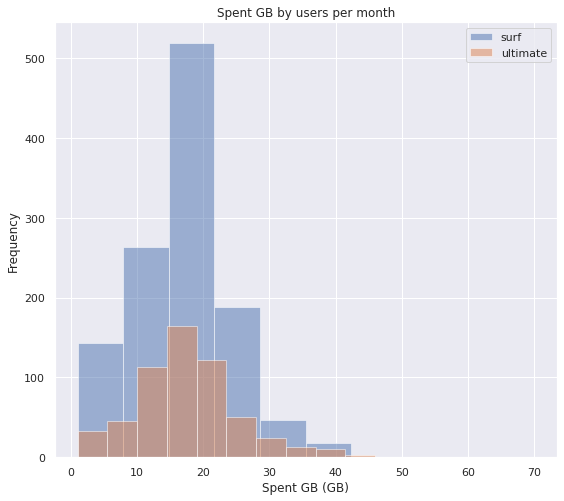

In [57]:
print('Media de GB gastados por usuario en plan Surf: ',mdf[mdf['plan']=='surf']['gb_used'].mean())
print('Media de GB gastados por usuario en plan Ultimate: ',mdf[mdf['plan']=='ultimate']['gb_used'].mean())
mdf[mdf['plan']=='surf']['gb_used'].hist( alpha=.5,figsize=[9,8])
mdf[mdf['plan']=='ultimate']['gb_used'].hist( alpha=.5)


plt.legend(['surf','ultimate'])
plt.title('Spent GB by users per month')
plt.ylabel('Frequency')
plt.xlabel('Spent GB (GB)')
plt.show()

In [58]:
# Calcula la media y la varianza de la cantidad de Mb mensuales gastados.
int_variance = np.var(int_merged)
int_mean= int_merged.mean()

print(f"La cantidad media de Mb gastados mensuales del plan Surf es : {int_mean.surf} Mb")
print(f"La varianza de los Mb gastados del plan Surf es : {int_variance.surf}")
print('')
print(f"La cantidad media de Mb gastados mensuales del plan Ultimate es : {int_mean.ultimate} Mb")
print(f"La varianza de los Mb gastados del plan Ultimate es : {int_variance.ultimate}")

La cantidad media de Mb gastados mensuales del plan Surf es : 14.64373317086933 Mb
La varianza de los Mb gastados del plan Surf es : 10.233571288223835

La cantidad media de Mb gastados mensuales del plan Ultimate es : 16.710870296465604 Mb
La varianza de los Mb gastados del plan Ultimate es : 12.671292140997743


Text(0.5, 1.0, 'Mb spent by plan')

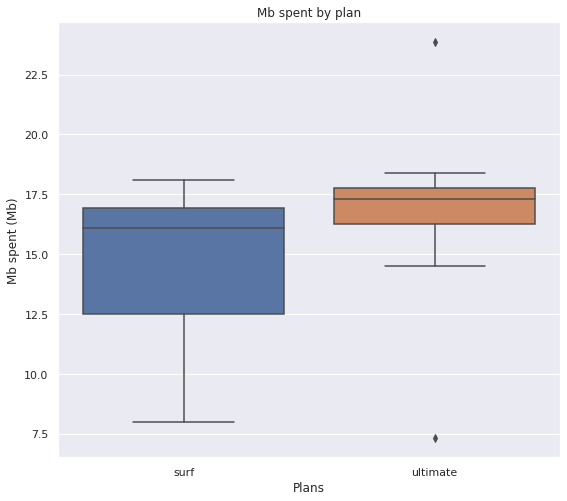

In [59]:
# Traza un diagrama de caja para visualizar la distribución de la cantidad de Mb gastados
box= int_merged.drop('month',axis=1)
box= pd.melt(box)

sns.boxplot(x='variable', y='value', data=box)
sns.set(rc={"figure.figsize":(9, 8)})
plt.ylabel('Mb spent (Mb)')
plt.xlabel('Plans')
plt.title('Mb spent by plan')


**Conclusiones:**

* **Para el plan 'Surf' podemos observar que el comportamiento de los usuarios respecto al consumo de datos podría mejorar y no precisamente obedece a la función del plan, esto debido a que:**
  * Los usuarios de este consumen 14.64Gb en promedio de manera mensual, esto debajo pero muy cerca del límite de datos incluidos (15GB).
  * podemos observar que la distribución tiene un sesgo negativo, esto indica que la Media es menor que la Mediana, por lo tanto genera una cola hacia la izquierda.
  * El 50% de los usuarios de este plan oscila entre los 12.5GB y 17 GB consumidos, la distribución de los datos se observa desde los 7.GB hasta los 17.6 GB aproximadamente.
  * Durante el periodo de Junio a Diciembre, los clientes suelen consumir más cantidad de gb del límite incluido, el máximo valor observado es de 18.1GB consumidos en diciembre, esto les genera un costo extra en su factura.
 
  
* **Para el plan 'Ultimate' podemos observar que el comportamiento de los usuarios si obedece a la función del plan, esto debido a que:**

    * Los usuarios de este consumen cerca de 16.7Gb en promedio de manera mensual, esto considerablemente debajo del límite de datos incluidos (30 GB).
    * podemos observar que la distribución tiene un sesgo negativo, esto indica que la Media es menor que la Mediana, por lo tanto genera una cola hacia la izquierda.
    
    * Se cuentan con dos valores outliers:
      * el primero corresponde al mes de enero con 7.3 GB consumidos 
      * el segundo corresponde al mes de marzo con 23.8 GB consumidos
    * **estos valores outliers pueden deberse a factores económicos o sociales, puede que tuvieramos menos clientes activos en enero, o que en marzo existiera algún evento importante como las olimpiadas y nuestros usuarios hayan decidido utilizar mucho consumo de streaming, aún siendo valores outliers, se observaron dentro de los límites de consumo establecidos.**

    
**En conclusión, el comportamiento de los usuarios respecto a los GB consumidos *si* varía en función del plan, a pesar de esto, los usuarios del plan Ultimate son los que mejor utilizan su plan especto a la "eficiencia" del consumo de datos incluidos. por otro lado, los usuarios del plan Surf suelen exceder el límite y pagar costos extra.
Se podría sugerir un rediseño de cantidad de GB incluidos para el plan Surf, esto para mejorar la fidelidad y satisfacción de nuestros clientes**

## Ingreso

In [60]:
month_mean_bill=mdf.groupby(['month','plan'])['bill'].mean()
month_mean_bill
month_mean_bill=month_mean_bill.reset_index()

bill_ult=month_mean_bill[month_mean_bill['plan']=='ultimate']
bill_surf=month_mean_bill[month_mean_bill['plan']=='surf']

bill_merged=pd.merge(bill_surf,bill_ult, on='month')
bill_merged.rename(columns={'bill_x':'surf','bill_y':'ultimate'},inplace=True)
bill_merged.index=np.arange(1,len(mes_merged)+1)
bill_merged.drop(['plan_x','plan_y'],axis=1,inplace=True)
bill_merged

,month,surf,ultimate
1,1,20.000000,70.000000
2,2,23.914000,70.000000
3,3,38.540625,78.000000
4,4,40.591429,73.062500
5,5,50.857170,71.000000
6,6,52.081000,72.081081
7,7,62.031124,72.382979
8,8,64.467143,72.456140
9,9,57.196871,71.380282
10,10,65.589337,72.147727


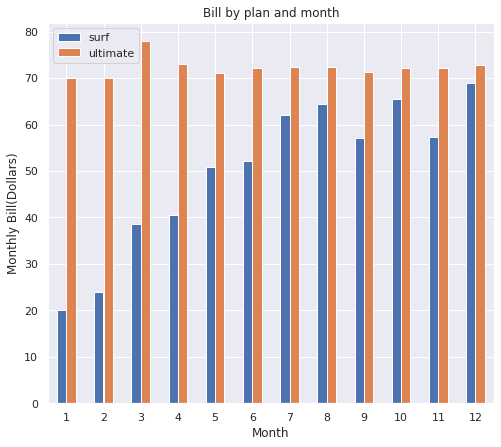

In [61]:
bill_merged[['surf','ultimate']].plot(kind='bar',rot=0, figsize=[8,7],
                                 xlabel='Month', ylabel='Monthly Bill(Dollars)', title='Bill by plan and month')

plt.legend(loc='upper left')
plt.show()

In [62]:
# # Compara el número de Dólares mensuales que los usuarios gastan para cada plan. Traza un histograma.
# bill_merged['surf'].hist(bins=4, alpha=.5)
# bill_merged['ultimate'].hist(bins=4, alpha=.5)
# plt.legend(['surf','ultimate'])
# plt.title('Dollars spent by users per month')
# plt.ylabel('Frequency')
# plt.xlabel('Dollars spent')
# plt.show()

Media de Dólares gastados por usuario en plan Surf:  60.52600847457627
Media de Dólares gastados por usuario en plan Ultimate:  72.27288428324698


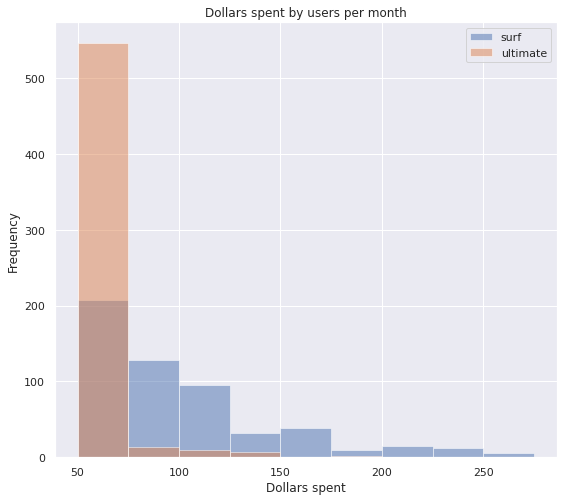

In [63]:
# Compara el número de Dólares mensuales que los usuarios gastan para cada plan. Traza un histograma.

print('Media de Dólares gastados por usuario en plan Surf: ',mdf[mdf['plan']=='surf']['bill'].mean())
print('Media de Dólares gastados por usuario en plan Ultimate: ',mdf[mdf['plan']=='ultimate']['bill'].mean())
mdf[mdf['plan']=='surf']['bill'].hist(bins=[50,75,100,125,150,175,200,225,250,275], alpha=.5,figsize=[9,8])
mdf[mdf['plan']=='ultimate']['bill'].hist(bins=[50,75,100,125,150,175,200,225,250,275], alpha=.5)


plt.legend(['surf','ultimate'])
plt.title('Dollars spent by users per month')
plt.ylabel('Frequency')
plt.xlabel('Dollars spent')
plt.show()

<div class="alert alert-block alert-info">
<b>Respuesta del estudiante: Se realiza el histograma con los datos completos, sin agrupar</b> <a class="tocSkip"></a>
</div>

In [64]:
# Calcula la media y la varianza de la cantidad de Mb mensuales gastados.
int_variance = np.var(bill_merged)
int_mean= bill_merged.mean()

print(f"La cantidad media de Dólares gastados mensuales del plan Surf es : {int_mean.surf} Dólares")
print(f"La varianza de los Dólares gastados del plan Surf es : {int_variance.surf}")
print('')
print(f"La cantidad media de Dólares gastados mensuales del plan Ultimate es : {int_mean.ultimate} Dólares")
print(f"La varianza de los Dólares gastados del plan Ultimate es : {int_variance.ultimate}")


La cantidad media de Dólares gastados mensuales del plan Surf es : 50.118535831573325 Dólares
La varianza de los Dólares gastados del plan Surf es : 238.65819884746986

La cantidad media de Dólares gastados mensuales del plan Ultimate es : 72.29223229580026 Dólares
La varianza de los Dólares gastados del plan Ultimate es : 3.879145118284608


Text(0.5, 1.0, 'Dollars spent by plan')

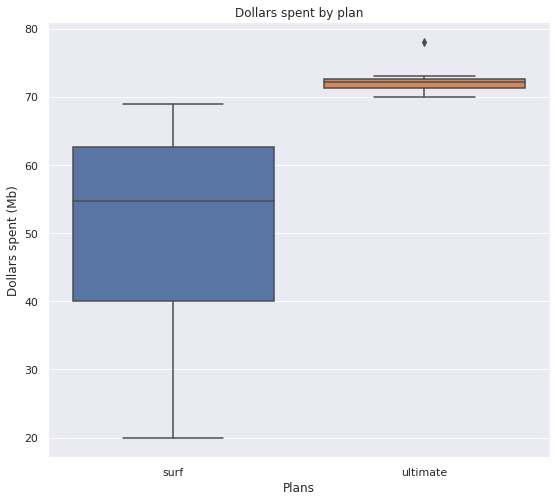

In [65]:
# Traza un diagrama de caja para visualizar la distribución de la cantidad de Dólares gastados por plan
box= bill_merged.drop('month',axis=1)
box= pd.melt(box)

sns.boxplot(x='variable', y='value', data=box)
sns.set(rc={"figure.figsize":(9, 8)})
plt.ylabel('Dollars spent (Mb)')
plt.xlabel('Plans')
plt.title('Dollars spent by plan')


**Conclusiones:**
 
* **Para el plan 'Surf' podemos observar que el comportamiento de los usuarios no obedece a la función del plan, esto debido a que:**
    * La varianza observada es alta (238), esto indica que la mayor parte de los datos están "alejados" de la media aritmética de la población, en otras palabras, la mayoría de los usuarios gastan un valor alejado de los 50 dolares.
    * Los usuarios gastan en promedio 50 dólares mensuales, esto implica un incremento del  250% en relación a la tarifa base (20 dls), esto a causa de las penalizaciones de consumos excedentes.
    * El 50% de los usuarios consume entre 40 y 62 dolares mensuales, la distribución de los datos se observa desde los 20 hasta los 68 dólares mensuales

* **Para el plan 'Ultimate' podemos observar que el comportamiento de los usuarios respecto a las mensajes si obedece a la función del plan, esto debido a que:**
  * La varianza observada es baja (3.8), esto indica que la mayor parte de los datos están cercanos a la media aritmética de la población, en otras palabras, la mayoría de los usuarios gastan un valor cercano a los 72 dólares.
  * existe solamente un outlier con un valor de 78 dólares, sin embargo, si bien estadísticamente se considera un outlier, sólo se eleva aproximadamente un 11.5% de la tarifa base, por otro lado, este outlier pertenece al mes de marzo, que vimos en el estudio de consumo de datos móviles que en ese mes hubo un incremento.
  * los datos se distribuyen entre los 70 y 73 dólares mensulaes, observamos muy poca varianza de los datos.
    
**En conclusión, los usuarios que utilizan su plan de manera más "eficiente" respecto a las tarifas, son los usuarios del plan Ultimate, esto debido a que no suelen ser penalizados por consumo excedente.**

**Respecto a los usuarios del plan surf, se sugiere realizar un nuevo estudio de mercado para verificar las necesidades de los usuarios, esto debido a que en promedio los usuarios gastan un 250% más de la tarifa base debido a las penalizaciones mensuales.**

## Prueba las hipótesis estadísticas


**Hipótesis nula: Los ingresos promedio procedentes de los planes de llamada Ultimate y Surf son iguales**

**Hipótesis alternativa: los ingresos promedio de los usuarios de los planes de llamada Ultimate y Surf son diferentes**

**valor alpha = .05**

In [66]:
# Prueba las hipótesis
#utilizamos la prueba estadística: Hipótesis sobre la igualdad de las medias de dos poblaciones
## NOTA ##
#se corrige y se utiliza la población completa, sin agrupar por mes#

alpha=.05
surf=mdf[mdf['plan']=='surf']['bill']
ultimate=mdf[mdf['plan']=='ultimate']['bill']

results= st.ttest_ind(surf,ultimate, equal_var=False)

#print(results)
pvalue=f'{results.pvalue/2:.15f}'
print('valor p: ',pvalue)

if results.pvalue/2 < alpha:
    print('Rechazamos la hipótesis nula')
    
else:
    print('No rechazamos la hipótesis nula')
print()
print('Los ingresos promedio procedentes de los usuarios del plan Surf son: ',surf.mean())
print('Los ingresos promedio procedentes de los usuarios del plan Ultimate son: ',ultimate.mean())




valor p:  0.000000000000470
Rechazamos la hipótesis nula

Los ingresos promedio procedentes de los usuarios del plan Surf son:  60.52600847457627
Los ingresos promedio procedentes de los usuarios del plan Ultimate son:  72.27288428324698


**Hipótesis nula: Los ingresos promedio procedentes de los usuarios del área NY-NJ son iguales a los de otras áreas**

**Hipótesis alternativa: los ingresos promedio de los usuarios de del área NY-NJ son diferentes a los de otras áreas**

**valor alpha = .05**

In [67]:
# Prueba las hipótesis
#utilizamos la prueba estadística: Hipótesis sobre la igualdad de las medias de dos poblaciones

ny_nj=mdf[mdf['city']=='New York-Newark-Jersey City, NY-NJ-PA MSA']['bill']

other_areas= mdf[mdf['city']!='New York-Newark-Jersey City, NY-NJ-PA MSA']['bill']

print()

alpha=.05

results2= st.ttest_ind(ny_nj,other_areas, equal_var=False)

pvalue=f'{results2.pvalue/2:.10f}'
print('valor p: ',pvalue)

if results2.pvalue/2 < alpha:
    print('Rechazamos la hipótesis nula')
    
else:
    print('No rechazamos la hipótesis nula')
    
    
print()
print('La cantidad de dolares mensuales promedio para el área NY-NJ es: ',ny_nj.mean())
print('La cantidad de dolares mensuales promedio para el resto de las áreas es: ',other_areas.mean())



valor p:  0.0023323806
Rechazamos la hipótesis nula

La cantidad de dolares mensuales promedio para el área NY-NJ es:  58.129175627240144
La cantidad de dolares mensuales promedio para el resto de las áreas es:  65.57341216216216


## Conclusión general

**Conclusiones**

Tenemos algunas conclusiones generales y por plan:

**Plan Surf:**
   * Los usuarios de este plan suelen ser los más penalizados por consumo excedente
   * La media de dólares gastados por usuario en este plan es de 60.52 dls
   * Los usuarios suelen tener buenas costumbres de consumo respecto a los minutos mensuales
   * Los usuarios suelen tener buenas costumbres de consumo respecto a los mensajes mensuales que su plan les ofrece.
   * Los usuarios suelen gastar más GB de los que su plan les ofrece mensualmente

   
   
**Este último punto hace que sus facturas sean muy altas, promediando los 60.52 dólares, lo cual no es redituable para el cliente.**

**Desde una visión enfocada a la fidelidad y satisfacción de cliente, puede que sea útil un nuevo estudio de mercado para este plan, ya sea incrementar un poco los precios y los beneficios mensuales de tarifa base, o en su defecto diseñar un nuevo plan "intermedio" que ofrezca beneficios en tarifa base que sean mayores a Surf pero menores a Ultimate**

**Desde una visión enfocada a la redituabilidad del plan de llamadas Surf, este plan es altamente redituable para la empresa, debido a que las penalizaciones mensuales promedian un incremento de un 302.6% en relación a la tarifa base (20 dls)**


**Plan Ultimate:**

   
   * Los usuarios de este plan suelen ser los menos penalizados
   * Los usuarios suelen gastar en promedio el 55.6% de su capacidad de GB mensuales (16.7 GB), lo cual se muestra sobrado en relación a los GB incluidos de tarifa base (30GB)
   * Los usuarios suelen gastar apenas un 4% de la cantidad de mensajes incluidos en tarifa base
   * Los usuarios suelen gastar apenas un 13.6% de la cantidad de minutos incluidos en tarifa base
   
**Este grupo de usuarios no suele ser penalizado, sin embargo tampoco aprovecha al máximo el beneficio de sus servicios incluidos en tarifa base.**

**Desde una visión enfocada a la fidelidad y satisfacción del cliente, puede que sea útil un estudio de mercado para rediseñar el plan, pudiendo tal vez reducir un 15% los precios del plan, así como reducir un 15% los beneficios del mismo, de esta manera el usuario seguiría gozando de una gran cantidad de beneficios, sin sacrificar precio y con bajo riesgo de penalizaciones**

**Desde una visión enfocada a la redituabilidad del plan de llamadas Ultimate, este plan es redituable no tanto por las penalizaciones, sino por el poco aprovechamiento del servicio por parte de sus usuarios, tienen un plan muy sobrado y consumen considerablemente menos de lo que pagan, por lo tanto la empresa gana con este comportamiento**



**Conclusiones generales:**

   * Observamos que para la hipótesis que los ingresos procedentes de los usuarios de ambos planes son diferentes, **se rechaza la Hipótesis Nula**, por lo tanto se **acepta la Hipótesis alternativa**, que establece que **los ingresos procedentes de los usuarios de ambos planes son diferentes**
   
   
   * Observamos que para la hipótesis que los ingresos procedentes de los usuarios del área NY-NJ comparado con los del resto de las áreas son diferentes, **se rechaza la Hipótesis Nula**, por lo tanto se **acepta la Hipótesis alternativa**, que establece que **los ingresos procedentes e los usuarios del área NY-NJ comparado con los del resto de las áreas son diferentes**
   
   
   
**Tal como menciono anteriormente, desde una visión enfocada a la redituabilidad, el plan más redituable conluiría que es el Surf, debido a la gran cantidad de penalizaciones que presentan los clientes, esto genera ingresos extas a la empresa**

**Sin embargo también consideramos que el plan Ultimate se vuelve redituable debido a los altos beneficios en servicios (llamadas, mensajeria, datos móviles) pagados por los clientes y que no son aprovechados, esto genera un menor consumo de recursos a la empresa, mientras el cliente sigue pagando tarifas "altas"**